In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import copy
import itertools
import os
import logging

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

In [ ]:
from captum.attr import GradientShap

In [ ]:
import warnings
warnings.filterwarnings('ignore', '.*does not have many workers.*')

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    from src import *

In [ ]:
OUTPUT_PLOTTING = False

if OUTPUT_PLOTTING:
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 7})
    plt.rc('text', usetex=True)
    plt.rcParams['figure.figsize'] = [4.77, 7.3]
else:
    plt.rcParams['figure.figsize'] = [10, 15]

In [ ]:
import yaml
with open('config-full.yml', 'r') as f:
    config = yaml.full_load(f)

In [ ]:
data_indexes = pd.read_csv('data/indexes_day.csv', parse_dates=['date'], dayfirst=True)
data_commodities = pd.read_csv('data/commodities_day.csv', parse_dates=['date'])
data_foreign = pd.read_csv('data/foreign_day.csv', parse_dates=['date'], dayfirst=True)
data_sectors = pd.read_csv('data/sectors_day.csv', parse_dates=['date'], dayfirst=True)
data_shares = pd.read_csv('data/shares_day.csv', parse_dates=['date'], dayfirst=True)
data_currencies = pd.read_csv('data/currencies_day.csv', parse_dates=['date'], dayfirst=True)
data_bonds = pd.read_csv('data/bonds_day.csv', parse_dates=['date'], dayfirst=True)

In [ ]:
data_day = multi_merge(
    data_indexes,
    data_commodities,
    data_foreign,
    data_sectors,
    data_shares,
    data_currencies,
    data_bonds,
    on='date',
    how='left',
)
data_day = data_day.sort_values('date').fillna(method='ffill').dropna()

In [ ]:
data_day = data_day.drop(
    [f'close_{i.lower()}' for i in ['1W', '1M', '6M', '1Y', '3Y', '5Y', '10Y', '20Y']],
    axis=1,
)

In [ ]:
for x in [c for c in data_day.columns if c.split('_')[0] == 'volume']:
    data_day.loc[data_day[x] < data_day[x].shift()*0.9, x] = data_day[x].shift()

In [ ]:
data_day = data_day.loc[
    (data_day.date <= '2019-11-01') & (data_day.date >= '2018-07-04')
]
data_day = data_day.reset_index()

## Data Plots

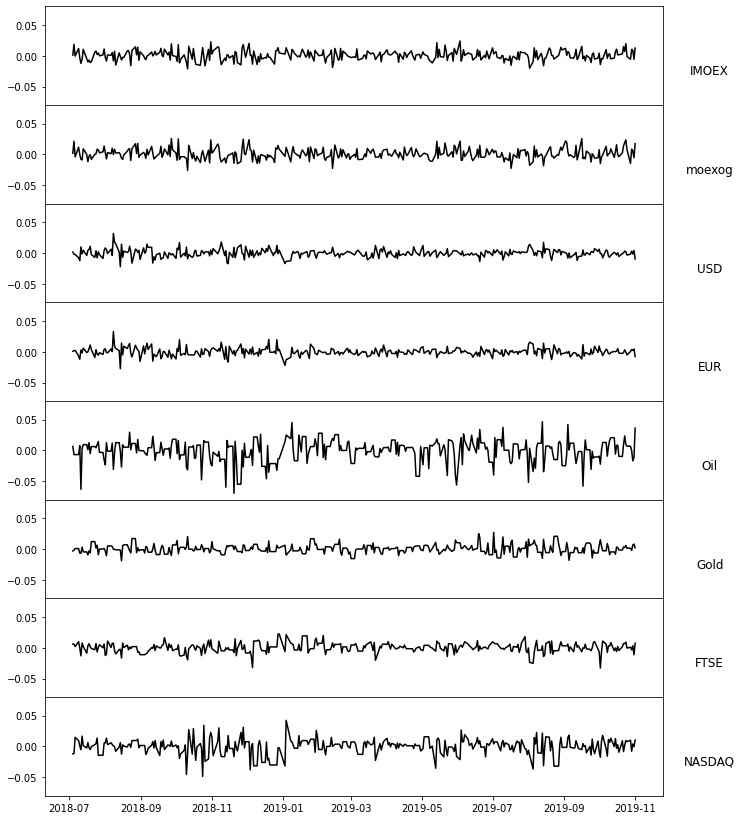

In [ ]:
fig = plt.figure(
    figsize=(
        plt.rcParams['figure.figsize'][0],
        round(plt.rcParams['figure.figsize'][0]*1.15, 1),
    )
)

gs = fig.add_gridspec(8, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].plot(data_day.date, data_day['return_imoex'], color='black')
axs[0].set_title('IMOEX', x=1.075, y=0.25)

axs[1].plot(data_day.date, data_day['return_moexog'], color='black')
axs[1].set_title('moexog', x=1.075, y=0.25)

axs[2].plot(data_day.date, data_day['return_usd'], color='black')
axs[2].set_title('USD', x=1.075, y=0.25)

axs[3].plot(data_day.date, data_day['return_eur'], color='black')
axs[3].set_title('EUR', x=1.075, y=0.25)

axs[4].plot(data_day.date, data_day['return_bz'], color='black')
axs[4].set_title('Oil', x=1.075, y=0.25)

axs[5].plot(data_day.date, data_day['return_gc'], color='black')
axs[5].set_title('Gold', x=1.075, y=0.25)

axs[6].plot(data_day.date, data_day['return_ukx'], color='black')
axs[6].set_title('FTSE', x=1.075, y=0.25)

axs[7].plot(data_day.date, data_day['return_ndx'], color='black')
axs[7].set_title('NASDAQ', x=1.075, y=0.25)

plt.ylim(-0.08, 0.08)
fig.tight_layout()

if OUTPUT_PLOTTING:
    fig.savefig('text/images/data.pdf', bbox_inches='tight')

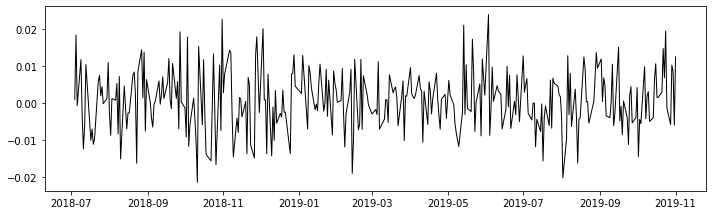

In [ ]:
plt.figure(
    figsize=(
        plt.rcParams['figure.figsize'][0],
        round(plt.rcParams['figure.figsize'][0]*0.31, 1),
    )
)
plt.plot(data_day.date, data_day.return_imoex, linewidth=1, color='black')
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/series.pdf', bbox_inches='tight')

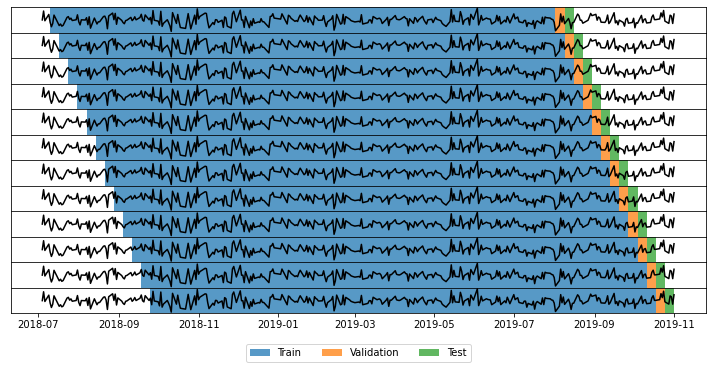

In [ ]:
fig = plt.figure(
    figsize=(
        plt.rcParams['figure.figsize'][0],
        round(plt.rcParams['figure.figsize'][0]*0.52, 1),
    )
)
gs = fig.add_gridspec(12, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

for i in range(12):
    axs[i].plot(data_day.date, data_day.return_imoex, color='black')
    axs[i].axvspan(
        data_day.date[5+(i*5)-1],
        data_day.date[340-65+(i*5)-1],
        alpha=0.75,
        color='C0',
        lw=0,
        label='Train',
    )
    axs[i].axvspan(
        data_day.date[340-65+(i*5)-1],
        data_day.date[340-60+(i*5)-1],
        alpha=0.75,
        color='C1',
        lw=0,
        label='Validation',
    )
    axs[i].axvspan(
        data_day.date[340-60+(i*5)-1],
        data_day.date[340-55+(i*5)-1],
        alpha=0.75,
        color='C2',
        lw=0,
        label='Test',
    )

plt.yticks([])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -1), ncol=3)

fig.tight_layout()
if OUTPUT_PLOTTING:
    fig.savefig('text/images/crossval.pdf', bbox_inches='tight')

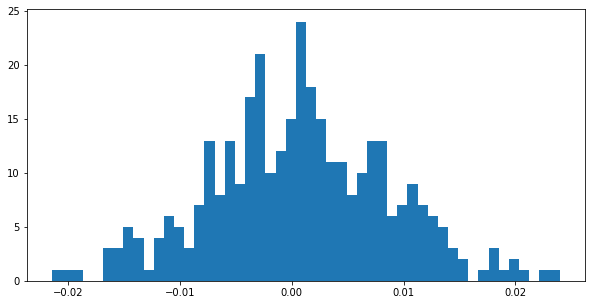

In [ ]:
plt.figure(
    figsize=(
        plt.rcParams['figure.figsize'][0], 
        plt.rcParams['figure.figsize'][0]/2
    )
)
plt.hist(data_day['return_imoex'], bins=50);

In [ ]:
data_commodities_toplot = data_commodities.loc[
    (data_commodities.date <= '2019-11-01') & (data_commodities.date >= '2018-07-04')
]

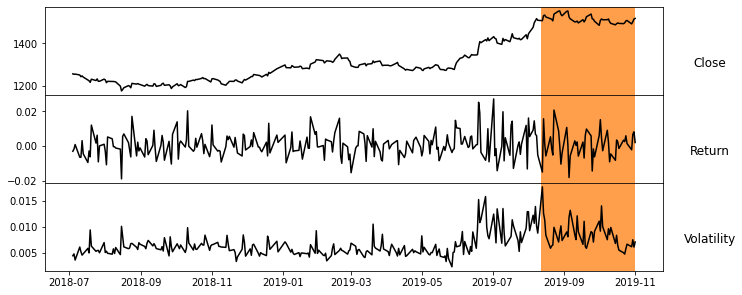

In [ ]:
fig = plt.figure(
    figsize=(
        plt.rcParams['figure.figsize'][0],
        round(plt.rcParams['figure.figsize'][0]*0.42, 1),
    )
)
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(
    data_commodities_toplot.date, 
    data_commodities_toplot['close_gc'], 
    color='black'
)
axs[0].set_title('Close', x=1.075, y=0.25)
axs[0].axvspan(
    pd.to_datetime('2019-08-12'),
    pd.to_datetime('2019-11-01'),
    alpha=0.75,
    color='C1',
    lw=0,
    label='Train',
)

axs[1].plot(
    data_commodities_toplot.date, 
    data_commodities_toplot['return_gc'], 
    color='black'
)
axs[1].set_title('Return', x=1.075, y=0.25)
axs[1].axvspan(
    pd.to_datetime('2019-08-12'),
    pd.to_datetime('2019-11-01'),
    alpha=0.75,
    color='C1',
    lw=0,
    label='Train',
)

axs[2].plot(
    data_commodities_toplot.date,
    data_commodities_toplot['volatility_gc'],
    color='black',
)
axs[2].set_title('Volatility', x=1.075, y=0.25)
axs[2].axvspan(
    pd.to_datetime('2019-08-12'),
    pd.to_datetime('2019-11-01'),
    alpha=0.75,
    color='C1',
    lw=0,
    label='Train',
)

fig.tight_layout()
if OUTPUT_PLOTTING:
    fig.savefig('text/images/gold.pdf', bbox_inches='tight')

In [ ]:
bad_loss = read_logs(
    'logs/model_cnnlstm_(256, 512)_32_2/period_2/version_7/metrics.csv')
good_loss = read_logs(
    'logs/model_cnnlstm_(256, 512)_32_2/period_2/version_5/metrics.csv')

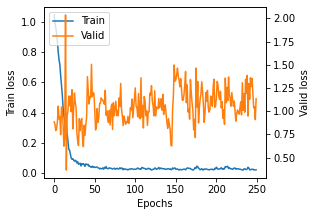

In [ ]:
figsize=(
    plt.rcParams['figure.figsize'][0]*0.45,
    round(plt.rcParams['figure.figsize'][0]*0.31, 1),
)
plt.figure(figsize=figsize)
plot_loss(
    good_loss['train_loss_epoch'],
    good_loss['valid_loss_epoch'],
)
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/good_loss.pdf', bbox_inches='tight')

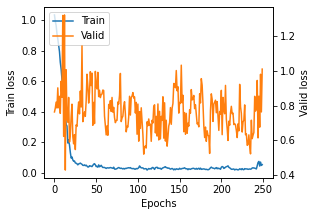

In [ ]:
figsize=(
    plt.rcParams['figure.figsize'][0]*0.45,
    round(plt.rcParams['figure.figsize'][0]*0.31, 1),
)
plt.figure(figsize=figsize)
plot_loss(
    bad_loss['train_loss_epoch'],
    bad_loss['valid_loss_epoch'],
)
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/bad_loss.pdf', bbox_inches='tight')

# Single Example

In [ ]:
test_end = pd.to_datetime('2019-10-13') + pd.Timedelta(days=7)
assert test_end.weekday() == 6
test_start = test_end - pd.Timedelta(days=7)
val_start = test_start - pd.Timedelta(days=7)
train_start = val_start - pd.Timedelta(days=7*4*12)

In [ ]:
data_ex = data_day.loc[(data_day.date >= train_start) & (data_day.date < test_end)]

In [ ]:
data = take_vars(
    data_ex, 
    idx=config['idx'], 
    var=config['var'], 
    add=config['add'],
)

In [ ]:
pl_data = MyDataModule(
    data, 
    target=config['target'],
    seq_length=config['seq_length'],
    batch_size=config['batch_size'],
    num_workers=0,
    split_lengths=[
        len(data)-config['seq_length']-2*config['test_length'], 
        config['test_length'], 
        config['test_length']
    ],
)

In [ ]:
torch.manual_seed(1)
pl_model = LitCNNLSTM(
    model_params=dict(
        input_size=data.shape[1],
        seq_length=config['seq_length'],
        cnn_channels=(32,64),
        kernel_size=(2,2),
        num_layers=1,
        hidden_size=32,
        bidirectional=False,
        fc_layers=0,
        fc_hidden_size=64,
        dropout=0),
    optimizer='Adam', 
    scheduler='ExponentialLR', 
    lr=0.001,
    wd=0.00,
    gamma=1, 
    loss='MSELoss'
)

In [ ]:
count_params(pl_model.model)

35681

In [ ]:
best_checkpointer = ModelCheckpoint(save_top_k=1, save_last=True, monitor='valid_loss', filename='best')
logger = CSVLogger(save_dir='')
printer = PrintMetricsCallback(metrics=['train_loss_epoch', 'valid_loss_epoch'])
lr_monitor = LearningRateMonitor(logging_interval ='epoch')

In [ ]:
v = logger.version
print(f'lightning_logs/vesion_{v}')

Missing logger folder: lightning_logs


lightning_logs/vesion_0


In [ ]:
trainer = pl.Trainer(
    log_every_n_steps=1, 
    logger=logger, 
    callbacks=[printer, best_checkpointer, lr_monitor], 
    max_epochs=100, 
    # resume_from_checkpoint=f'lightning_logs/version_{v}/checkpoints/last.ckpt' 
)
trainer.fit(pl_model, pl_data)

In [ ]:
y_true, y_pred = process_predcit(trainer.predict(pl_model, dataloaders=pl_data.predict_dataloader()))

Predicting: 4it [00:00, ?it/s]

In [ ]:
print('zero:', mse(
    y_true[-2*config['test_length']:-config['test_length']], 
    np.zeros_like(y_true[-2*config['test_length']:-config['test_length']])
))
print('model:', mse(
    y_true[-2*config['test_length']:-config['test_length']], 
    y_pred[-2*config['test_length']:-config['test_length']]
))

zero: 0.5090672
model: 1.2176511


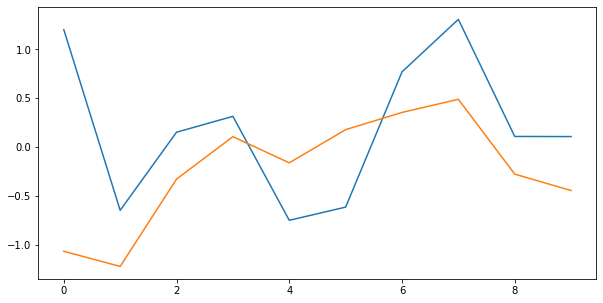

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_true[-2*config['test_length']:])
plt.plot(y_pred[-2*config['test_length']:])

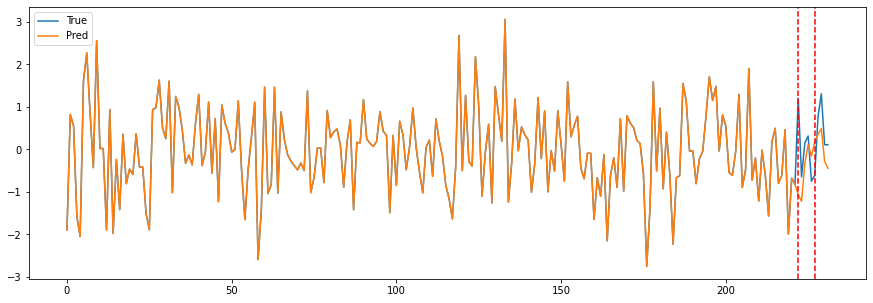

In [ ]:
plt.figure(figsize=(15,5))
plot_predictions(
    y_pred, y_true, 
    splits=[len(pl_data.train_dataset), len(pl_data.train_dataset)+len(pl_data.val_dataset)]
);

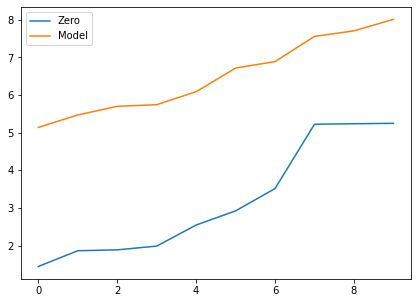

In [ ]:
plt.figure(figsize=(7,5))
plot_cumsum(y_pred[-10:], y_true[-10:]);

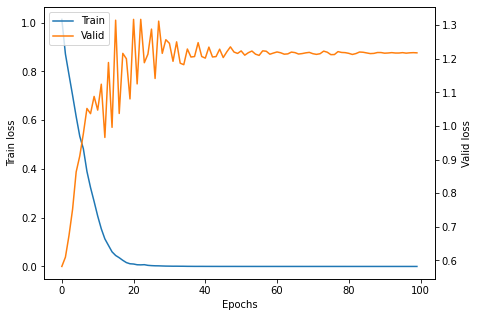

In [ ]:
logs = read_logs(f'lightning_logs/version_{v}/metrics.csv')
plt.figure(figsize=(7,5))
plot_loss(logs['train_loss_epoch'], logs['valid_loss_epoch']);
# plt.yscale('log')

# Model Training

In [ ]:
with open('config-imoex.yml', 'r') as f:
    config = yaml.full_load(f)

In [ ]:
N_SPLITS = 12
N_VERSIONS = 10

In [ ]:
data_cv_full = data_day.loc[data_day.date <= '2019-11-01']

data_cv = take_vars(
    data_cv_full.set_index('date'), 
    idx=config['idx'], 
    var=config['var'],
    add=config['add'],
)

In [ ]:
torch.manual_seed(1)
pl_model = LitCNNLSTM(
    model_params=dict(
        input_size=data_cv.shape[1],
        seq_length=config['seq_length'],
        cnn_channels=(256,512),
        kernel_size=(2,2),
        num_layers=1,
        hidden_size=32,
        bidirectional=False,
        fc_layers=None,
        fc_hidden_size=64,
        dropout=0.1),
    optimizer='Adam', 
    scheduler='ExponentialLR', 
    lr=0.001, 
    wd=0.001, 
    gamma=1, 
    loss='MSELoss')

In [ ]:
parameter_grid = (
    [(64, 128), (128, 256), (256, 512), (512, 1024)], 
    [16, 32, 64], 
    [1, 2]
)

In [ ]:
variable_grid = ['commodities', 'currencies', 'foreign', 'bonds', 'shares', 'sectors']

def prepare_data_cv(data_cv_full, variable):
    idx = [c.split('_')[-1] for c in data_cv_full.columns
           if c.split('_')[-1].upper() not in groupdict[variable]]
    add = ['yield'] if variable != 'bonds' else None
    data_cv = take_vars(
        data_cv_full, 
        idx=idx, 
        var=config['var'], 
        add=add
    )
    return data_cv

In [ ]:
for cnn_channels, lstm_hidden_size, lstm_layers in itertools.product(*parameter_grid):

# for variable in variable_grid:
#     data_cv = prepare_data_cv(data_cv_full, variable)

    pl_model = LitCNNLSTM(
        model_params=dict(
            input_size=data_cv.shape[1],
            seq_length=config['seq_length'],
            cnn_channels=cnn_channels,
            kernel_size=(2, 2),
            num_layers=lstm_layers,
            hidden_size=lstm_hidden_size,
            bidirectional=False,
            fc_layers=None,
            fc_hidden_size=64,
            dropout=0.1,
        ),
        optimizer='Adam',
        scheduler='ExponentialLR',
        lr=0.001,
        wd=0.001,
        gamma=1,
        loss='MSELoss',
    )

    model_name = f'cnnlstm_{cnn_channels}_{lstm_hidden_size}_{lstm_layers}'
    tss = TimeSeriesSplit(
        n_splits=N_SPLITS,
        max_train_size=5*52+10+config['seq_length'],
        test_size=5,
    )
    splits = tss.split(data_cv)

    for i, (train_idx, test_idx) in enumerate(splits):
        data_split = data_cv.iloc[np.concatenate((train_idx, test_idx))]
        pl_data = MyDataModule(
            data_split,
            target=config['target'],
            seq_length=config['seq_length'],
            batch_size=config['batch_size'],
            num_workers=0,
            split_lengths=[
                len(data_split)-config['seq_length']-2*config['test_length'], 
                config['test_length'], 
                config['test_length']
            ],
        )

        for j in range(N_VERSIONS):
            torch.manual_seed(j)
            pl_model.model.init_weights()

            checkpointer = ModelCheckpoint(
                dirpath=None,
                filename='best',
                save_top_k=0,
                save_last=True,
                monitor='valid_loss',
            )
            logger = CSVLogger(
                save_dir=f'logs/', 
                name=f'model_{model_name}/period_{i}', 
                version=j
            )
            trainer = pl.Trainer(
                log_every_n_steps=1,
                logger=logger,
                callbacks=[checkpointer],
                max_epochs=250,
                check_val_every_n_epoch=1,
                enable_progress_bar=False,
            )
            trainer.fit(pl_model, pl_data)
            pl_model.eval()

            y_true, y_pred = process_predcit(
                trainer.predict(
                    model=pl_model, dataloaders=pl_data.predict_dataloader()
                )
            )
            pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).to_csv(
                f'logs/model_{model_name}/period_{i}/version_{j}/results.csv',
                index=False,
            )

            fig = plt.figure(figsize=(24,6))
            plot_predictions(
                y_pred,
                y_true,
                splits=(
                    len(pl_data.train_dataset),
                    len(pl_data.train_dataset)+len(pl_data.val_dataset),
                ),
            )
            fig.savefig(
                f'logs/model_{model_name}/period_{i}/version_{j}/series.png',
                format='png',
                bbox_inches='tight',
            )

            fig = plt.figure(figsize=(24,6))
            plot_predictions(y_pred[-10:], y_true[-10:], splits=[5])
            fig.savefig(
                f'logs/model_{model_name}/period_{i}/version_{j}/test.png',
                format='png',
                bbox_inches='tight',
            )

            fig = plt.figure(figsize=(8,6))
            plot_cumsum(y_pred[-10:], y_true[-10:])
            fig.savefig(
                f'logs/model_{model_name}/period_{i}/version_{j}/cumsum.png',
                format='png',
                bbox_inches='tight',
            )

            logs = read_logs(
                f'logs/model_{model_name}/period_{i}/version_{j}/metrics.csv'
            )
            fig = plt.figure(figsize=(8,6))
            plot_loss(logs['train_loss_epoch'], logs['valid_loss_epoch'])
            fig.savefig(
                f'logs/model_{model_name}/period_{i}/version_{j}/loss.png',
                format='png',
                bbox_inches='tight',
            )

## Result Images & Tables

In [ ]:
logs_table_cnnlstm = read_model_logs('cnnlstm_(256, 512)_32_2')
logs_table_cnn = read_model_logs('cnn_(128, 256, 512)')

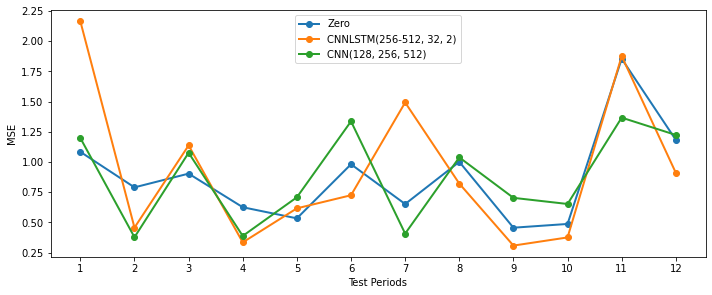

In [ ]:
figsize=(
    plt.rcParams['figure.figsize'][0],
    round(plt.rcParams['figure.figsize'][0]*0.42, 1),
)
fig = plt.figure(figsize=figsize)

plot_result_min(
    logs_table_cnnlstm, 
    split='test',
    colors=['C0', 'C1']
)
plot_result_min(
    logs_table_cnn, 
    split='test',
    colors=['C0', 'C2'],
    plot_zero=False
)
plt.xticks(range(1, 13))
plt.xlabel('Test Periods')
plt.ylabel('MSE')
plt.legend(('Zero', 'CNNLSTM(256-512, 32, 2)', 'CNN(128, 256, 512)'))
plt.tight_layout()
if OUTPUT_PLOTTING:
    fig.savefig('text/images/periods.pdf', bbox_inches='tight')

In [ ]:
logs_table = read_model_logs('cnnlstm_(256, 512)_32_2')

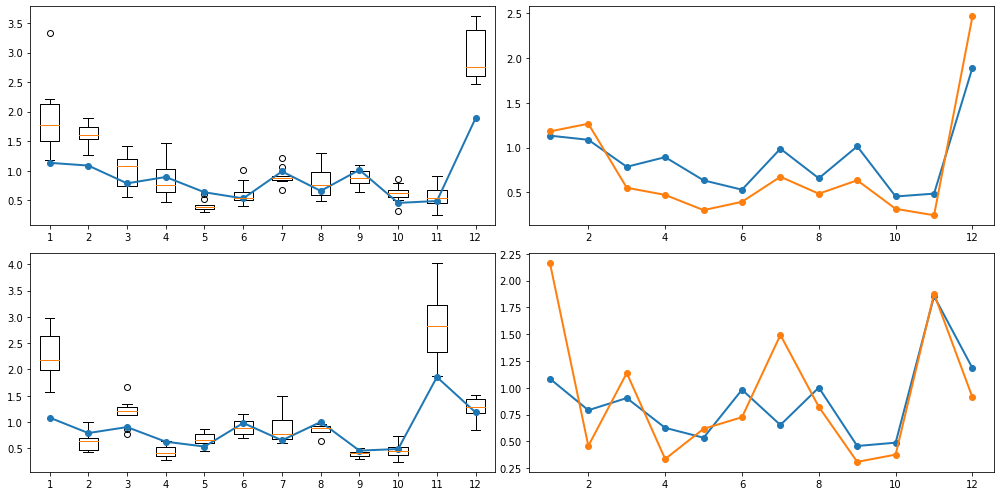

In [ ]:
figsize=(14, 7)
fig, axs = plt.subplots(2, 2, figsize=figsize)

plot_result_box(
    logs_table,
    ax=axs[0,0],
    split='val',
)
plot_result_box(
    logs_table, 
    ax=axs[1,0],
    split='test',
)
plot_result_min(
    logs_table, 
    ax=axs[0,1],
    split='val',
)
plot_result_min(
    logs_table,
    ax=axs[1,1],
    split='test',
)
plt.tight_layout()

In [ ]:
parameter_grid = (
    [(64, 128), (128, 256), (256, 512), (512, 1024)], 
    [16, 32, 64], 
    [1, 2]
)

reses = []
for cnn_channels, lstm_hidden_size, lstm_layers in tqdm(itertools.product(*parameter_grid)):
    try:
        model_name = f'cnnlstm_{cnn_channels}_{lstm_hidden_size}_{lstm_layers}'
        logs_table = read_model_logs(model_name)
        reses.append(res_table(logs_table, model_name=model_name))
    except FileNotFoundError:
        pass
results_cnnlstm = pd.concat(reses).drop_duplicates()
results_cnnlstm['mean'] = results_cnnlstm.mean(1)

0it [00:00, ?it/s]

In [ ]:
results_cnnlstm

,0,1,2,3,4,5,6,7,8,9,10,11,mean
naive_zero,1.084207,0.789920,0.903775,0.625402,0.533294,0.981392,0.651897,1.001440,0.455847,0.486915,1.855148,1.182864,0.879342
"cnnlstm_(64, 128)_16_1",1.725680,0.583918,1.075668,0.222826,0.698383,1.219975,0.894049,1.131066,0.573031,1.028348,2.839865,1.944614,1.161452
"cnnlstm_(64, 128)_16_2",2.559620,0.835857,1.379948,0.338514,1.028442,1.040765,1.064110,0.899674,0.708145,0.552507,1.120396,1.354305,1.073524
"cnnlstm_(128, 256)_16_1",1.615080,0.818005,1.175452,0.534533,0.595252,1.085599,0.639225,0.772184,0.341028,0.757814,2.598431,1.134698,1.005608
"cnnlstm_(128, 256)_16_2",2.090357,0.686355,1.341090,0.637680,0.822901,1.210285,0.654068,0.674558,0.490512,0.407613,3.214273,0.870333,1.091669
"cnnlstm_(128, 256)_32_1",1.963899,0.649777,1.054439,0.357530,0.593033,0.958119,0.370554,1.099717,0.381421,0.259324,3.469294,1.033451,1.015880
"cnnlstm_(128, 256)_32_2",2.193460,0.473315,1.006763,0.510721,0.887634,1.174677,1.278151,0.635263,0.417851,0.437658,2.600516,1.123497,1.061625
"cnnlstm_(128, 256)_64_1",1.530853,0.702129,0.948381,0.448279,0.507965,0.897764,0.448050,0.999912,0.487872,0.600639,2.695995,0.759840,0.918973
"cnnlstm_(128, 256)_64_2",1.786594,0.660737,0.676640,0.487784,0.395702,0.935503,0.818038,0.868373,0.463324,0.395581,3.042675,1.300300,0.985938
"cnnlstm_(256, 512)_16_1",1.439839,0.698378,1.196187,0.435654,0.427323,1.121458,0.661110,1.407293,0.409264,0.765655,2.914183,1.468481,1.078735


In [ ]:
parameter_grid = (
    [(32, 64, 128), (64, 128, 256), (128, 256, 512), (256, 512, 1024)]
)

reses = []
for cnn_channels in tqdm(parameter_grid):
    try:
        model_name = f'cnn_{cnn_channels}'
        logs_table = read_model_logs(model_name)
        reses.append(res_table(logs_table, model_name=model_name))
    except FileNotFoundError:
        pass
    
results_cnn = pd.concat(reses).drop_duplicates()
results_cnn['mean'] = results_cnn.mean(1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
results_cnn

,0,1,2,3,4,5,6,7,8,9,10,11,mean
naive_zero,1.084207,0.789920,0.903775,0.625402,0.533294,0.981392,0.651897,1.001440,0.455847,0.486915,1.855148,1.182864,0.879342
"cnn_(32, 64, 128)",0.909721,0.855755,2.994998,1.032133,1.229262,2.588746,0.795983,1.872292,0.931491,0.489749,2.573570,1.350935,1.468720
"cnn_(64, 128, 256)",1.533444,0.453785,1.936684,0.561657,0.654938,1.733350,1.536259,1.332375,0.780439,0.560302,2.671129,1.369079,1.260287
"cnn_(128, 256, 512)",1.198500,0.377109,1.076361,0.387640,0.707889,1.336772,0.407037,1.038175,0.703146,0.652376,1.367416,1.224045,0.873039
"cnn_(256, 512, 1024)",1.571184,0.493354,1.214716,1.274950,0.829687,0.933089,0.690863,1.438147,0.588975,0.605124,2.486258,1.017099,1.095287


In [ ]:
reses_vars = []
for variable in tqdm(['', 'bonds', 'commodities', 'currencies', 'sectors', 'shares', 'foreign']):
    try:
        if variable != '':
            model_name = f'cnnlstm_(256, 512)_32_2_{variable}'
            logs_table = read_model_logs(model_name)
            reses_vars.append(res_table(logs_table, model_name=model_name))
        else:
            model_name = f'cnnlstm_(256, 512)_32_2'
            logs_table = read_model_logs(model_name)
            reses_vars.append(res_table(logs_table, model_name=model_name))
    except FileNotFoundError:
        pass
results_v = pd.concat(reses_vars).drop_duplicates()
results_v['mean'] = results_v.mean(1)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
results_v

,0,1,2,3,4,5,6,7,8,9,10,11,mean
naive_zero,1.084207,0.789920,0.903775,0.625402,0.533294,0.981392,0.651897,1.001440,0.455847,0.486915,1.855148,1.182864,0.879342
"cnnlstm_(256, 512)_32_2",2.165429,0.456618,1.137460,0.334354,0.616274,0.724728,1.492859,0.821274,0.307773,0.375335,1.876807,0.910344,0.934938
"cnnlstm_(256, 512)_32_2_bonds",2.353072,0.428589,0.912536,0.604241,0.866914,1.215742,0.394774,0.867876,0.306059,0.701605,2.897361,1.148645,1.058118
"cnnlstm_(256, 512)_32_2_commodities",2.281112,0.763535,0.778844,0.365986,0.985211,0.720236,1.131478,0.665602,0.402993,0.641332,2.673188,1.131190,1.045059
"cnnlstm_(256, 512)_32_2_currencies",2.700101,0.583982,1.046894,0.688824,1.086389,1.147900,0.437639,0.914998,0.291701,0.787789,2.766855,1.284126,1.144766
"cnnlstm_(256, 512)_32_2_sectors",2.518902,0.455415,0.569995,0.440194,0.918898,0.769452,0.408783,0.695899,0.428704,0.595300,2.698879,0.812797,0.942768
"cnnlstm_(256, 512)_32_2_shares",2.120194,1.223290,1.583899,0.391768,0.210872,1.019038,0.585499,0.781230,0.409285,0.480843,3.945036,0.716530,1.122290
"cnnlstm_(256, 512)_32_2_foreign",1.710200,0.865228,0.731647,0.484042,0.598876,0.930926,0.917432,0.973414,0.523347,0.521082,1.887322,1.355396,0.958243


# SHAP

In [ ]:
with open('config-full.yml', 'r') as f:
    config = yaml.full_load(f)

In [ ]:
data_shap = data_day.loc[data_day['date'] <= '2019-11-01']

data_shap = take_vars(
    data_shap.set_index('date'),
    idx=config['idx'],
    var=config['var'],
    add=config['add'],
)

In [ ]:
N_SPLITS = 12
model_name = 'cnnlstm_(256, 512)_32_2'

In [ ]:
tss = TimeSeriesSplit(
    n_splits=N_SPLITS, max_train_size=5*52+10+config['seq_length'], test_size=5
)
splits = tss.split(data_shap)
logs_table = read_model_logs(model_name)
best_logs = logs_table.iloc[logs_table.groupby('period')[f'val_mse'].idxmin()]

attr_shap_total = []
input_total = []
targets_total = []
y_true_total = []
y_pred_total = []
for i, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_SPLITS):
    data_split = data_shap.iloc[np.concatenate((train_idx, test_idx))]
    pl_data = MyDataModule(
        data_split,
        target=config['target'],
        seq_length=config['seq_length'],
        batch_size=config['batch_size'],
        num_workers=0,
        split_lengths=[
            len(data_split)-config['seq_length']-2*config['test_length'], 
            config['test_length'], 
            config['test_length']
        ],
    )
    
    j = int(best_logs.loc[best_logs['period'] == 0].version)
    pl_model = LitCNNLSTM.load_from_checkpoint(
        f'logs/model_{model_name}/period_{i}/version_{j}/checkpoints/last.ckpt'
    )
    pl_model.eval()

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        logging.getLogger('pytorch_lightning').setLevel(logging.WARNING)
        y_true, y_pred = process_predcit(
            pl.Trainer(enable_progress_bar=False, logger=False).predict(
                model=pl_model, dataloaders=pl_data.test_dataloader()
            )
        )

    x, y, t = next(iter(pl_data.test_dataloader()))
    x = torch.cat((x, y), dim=2)
    torch.manual_seed(2)
    x.requires_grad_()
    baseline = torch.zeros_like(x)
    attr_shap = GradientShap(pl_model.model).attribute(x, baseline).detach()
    x = x.detach()

    attr_shap_total.append(attr_shap)
    input_total.append(x)
    targets_total.append(t)
    y_true_total.append(y_true)
    y_pred_total.append(y_pred)

attr_shap_total = torch.cat(attr_shap_total)
input_total = torch.cat(input_total)
targets_total = torch.cat(targets_total)
y_true_total = torch.cat(y_true_total)
y_pred_total = torch.cat(y_pred_total)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
feature_names = list(data_split.columns)
feature_names.append(feature_names.pop(feature_names.index('return_imoex')))

In [ ]:
plotter = AttributionPlotter(
    feature_names=feature_names, 
    attributions=attr_shap_total, 
    inputs=input_total
)

## Series

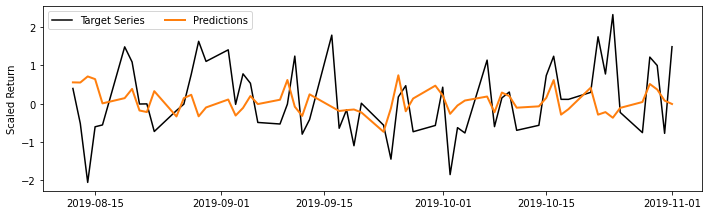

In [ ]:
figsize=(
        plt.rcParams['figure.figsize'][0],
        round(plt.rcParams['figure.figsize'][0]*0.31, 1),
    )
plt.figure(figsize=figsize)
plt.plot(
    data_day.date[-60:], y_true_total, color='black', label='Target Series'
)
plt.plot(
    data_day.date[-60:], y_pred_total, linewidth=2, color='C1', label='Predictions'
)
plt.ylabel('Scaled Return')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/preds.pdf', bbox_inches='tight')

## Lags

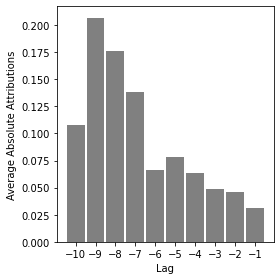

In [ ]:
figsize=(
        plt.rcParams['figure.figsize'][0]*0.4,
        plt.rcParams['figure.figsize'][0]*0.4,
    )
plt.figure(figsize=figsize)
plt.bar(
    x=range(-10, 0),
    height=np.abs(attr_shap_total.sum(2)).mean(0),
    width=0.9,
    color='grey',
)
plt.xticks(range(-10, 0))
plt.xlabel('Lag')
plt.ylabel('Average Absolute Attributions')
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/lags.pdf', bbox_inches='tight')

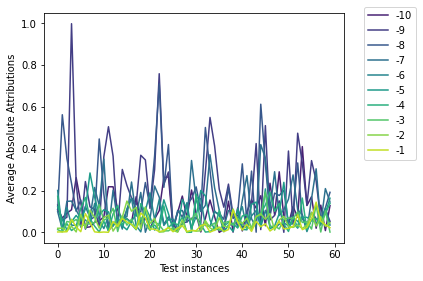

In [ ]:
figsize=(
    plt.rcParams['figure.figsize'][0]*0.6,
    plt.rcParams['figure.figsize'][0]*0.4,
)
plt.figure(figsize=figsize)

sns.lineplot(data=np.abs(attr_shap_total.sum(2)), palette='viridis', dashes=False)
plt.legend(range(-10, 0), bbox_to_anchor=(1.05, 1.05))
plt.xlabel('Test instances')
plt.ylabel('Average Absolute Attributions')
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/lags_series.pdf', bbox_inches='tight')

## Local

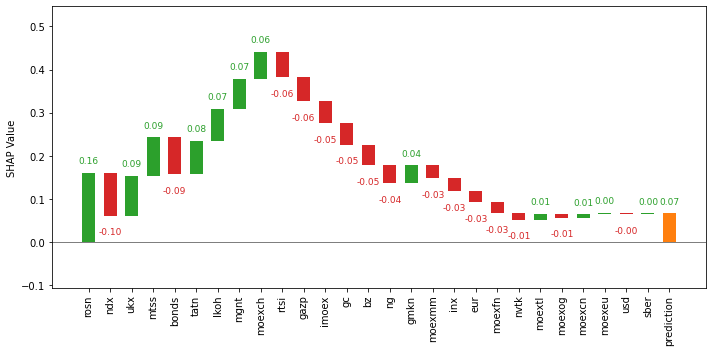

In [ ]:
fig = plt.figure(figsize=(10,5))
plotter.plot_local(day=20)
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/local.pdf')

## Global

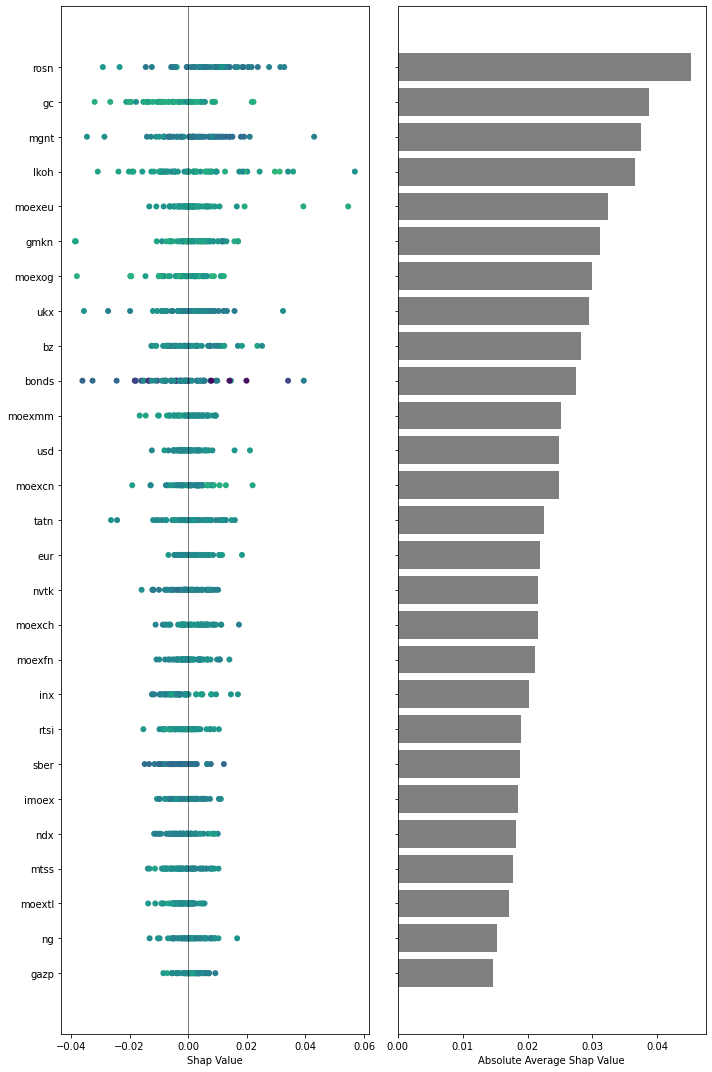

In [ ]:
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1]))
gs = fig.add_gridspec(1,2, hspace=0)
ax = gs.subplots(sharey=True)

plotter.plot_global_scatter(ax=ax[0])
plotter.plot_global_bar(ax=ax[1])

plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/beeswarm.pdf')

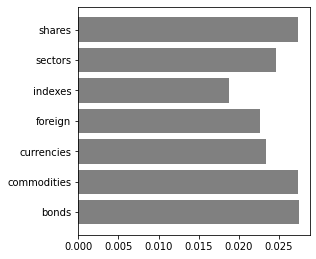

In [ ]:
figsize=(
    plt.rcParams['figure.figsize'][0]*0.45,
    round(plt.rcParams['figure.figsize'][0]*0.37, 1),
)
plt.figure(figsize=figsize)

plotter.plot_indexes()
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/classes.pdf')

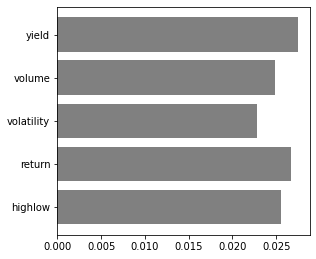

In [ ]:
figsize=(
    plt.rcParams['figure.figsize'][0]*0.45,
    round(plt.rcParams['figure.figsize'][0]*0.37, 1),
)
plt.figure(figsize=figsize)
plotter.plot_variables()
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/types.pdf')

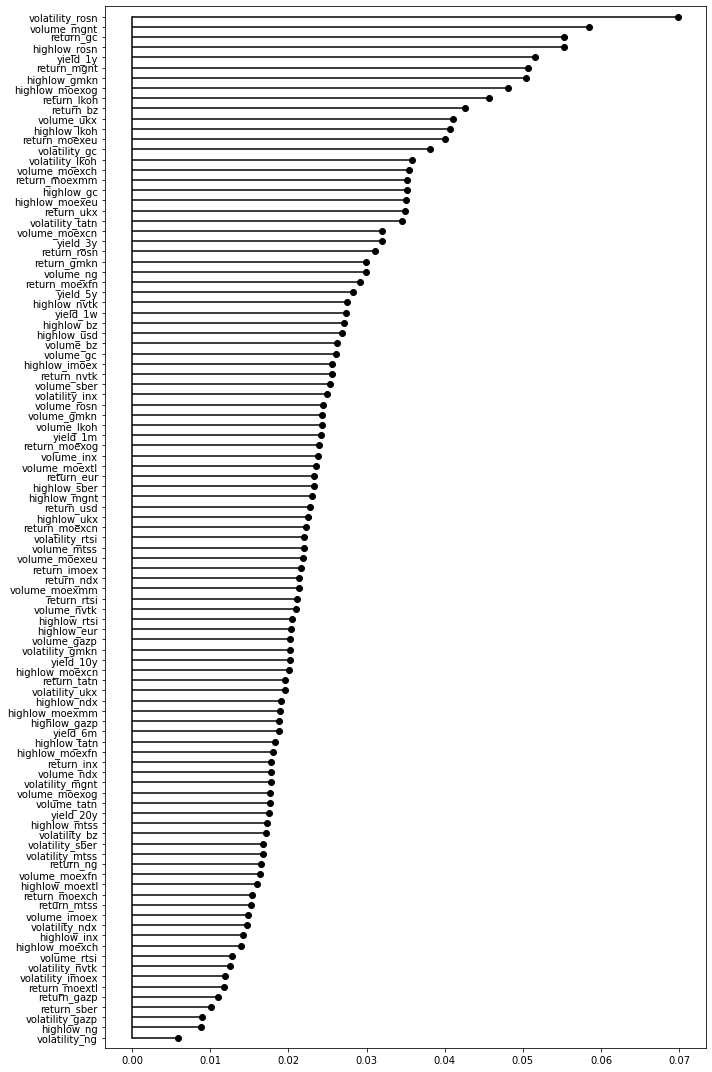

In [ ]:
figsize=(
    plt.rcParams['figure.figsize'][0],
    plt.rcParams['figure.figsize'][1]
)
plt.figure(figsize=figsize)

plotter.plot_global_all_stem()
plt.tight_layout()
if OUTPUT_PLOTTING:
    plt.savefig('text/images/all_vars_shap.pdf')